# Where to find referenced equations: 

[1] H. Owhadi and G. R. Yoo. Kernel flows: From learning kernels from data into the abyss. *Journal of Computational Physics*, 389:22–47, 2019. <br>
[2] B. Hamzi and H. Owhadi. Learning dynamical systems from data: a simple cross-validation perspective. *CoRR, abs/2007.05074* 2020.<br>
[3] F. Hoffmann, B. Hosseini, Z. Ren, and A. Stuart. Consistency of semi-supervised learning algorithms on graphs: Probit and one-hot methods. *Journal of Machine Learning Research 21*, 1-55, 2019

# Functions needed to compute u*

In [2]:
import torch
from torch.autograd import Variable
import scipy.optimize

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return torch.reciprocal(torch.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*torch.exp(-1.0/g*X)*torch.reciprocal(torch.exp(-1.0/g*X)+1.)**2

# Weight function returned by kernel Function
def weight(X, N_lst, r, eps):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    eps - gives perturbed kernel if eps != 0
    r - threshold in kernel function
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = int(*N_lst.size())
    W = torch.zeros(N,N)
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist = torch.linalg.norm(X[i]-X[j])**2
            if dist<=r:
                W[count_i][count_j] = 1
            W[count_i][count_j] += eps*torch.exp(-dist/(r+eps)**2)

    W.fill_diagonal_(0)
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, eps, alpha, tau, r):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    '''
    N = int(*N_lst.size())
    W = weight(X,N_lst,r,eps)
    D = torch.diag(torch.sum(W,1))
    L = D - W
    return (1/tau**2*(L + tau**2*torch.eye(N)))**alpha

# truncated version of Covariance defined in [3]-(62)
def Cov_truncated(X, N_lst, eps, alpha, tau, r, n_eig):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    n_eig - eigenvlue cutoff for truncated [3]-(62)
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    W = weight(X,N_lst,r,eps)
    D = torch.diag(torch.sum(W,1))
    L = D - W
    LE, LV = torch.linalg.eig(L)
    LE = LE.float(); LV = LV.float()

    CE = (1/tau**2*(LE + tau**2))**alpha
    N = int(*N_lst.size())
    C = torch.zeros(N,N)
    for k in range(n_eig):
        C = C + 1/CE[k]*torch.outer(LV[:,k],(LV[:,k].T))
    return C

# Array given by Fj in [3] - (12), (13)
def F_sum(N_lst, g, y, Z_p, u):
    '''
    N_lst - list of indices used
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    N = int(*N_lst.size())
    Fj = torch.zeros(N)
    for Z_j in Z_p:
        u_j = torch.where(N_lst == Z_j)
        basis=torch.zeros(N);basis[u_j]=1.0
        Fj = Fj + y[Z_j]*psi(y[Z_j]*u[u_j], g)/cap_psi(y[Z_j]*u[u_j], g)*basis
    return Fj


# Function needed for fsolve using EL given in [3]-(2)
def u_ast_EL(X, N_lst, g, alpha, tau, eps, rval, y, Z_p, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    x_0 - initial u_0 to minimize (if undefined, x_0 = vector of zeros)
    '''
    if not torch.is_tensor(N_lst):
        N_lst = torch.arange(N_lst)

    N = int(*N_lst.size())
    if x_0: x_0 = torch.zeros(N)
    n_eig = 20 #[3]-(62) truncation
    C = Cov_truncated(X, N_lst, eps, alpha, tau, rval, n_eig)
    def final(u):
    #     C = Cov(X, N, eps, alpha, tau, rval)
    
        return u-(C.float()@F_sum(N_lst, g, y, Z_p, u)).detach().numpy()
        
#         return u - torch.matmul(C,F_sum(N_lst, g, y, Z_p, u))
    return torch.tensor(scipy.optimize.fsolve(final, x_0))


In [11]:

# -----------Newton's Method----------------------------------

# Newtons method function
def newton(f, x0, tol=1e-05, maxiter=50):
    '''
    f - input function
    x0 - initialization
    tol - tolerance for step size
    '''
    x = Variable(x0, requires_grad = True)
#     for _ in range(maxiter):
#         val = f(x)
#         val.backward()
#         step = (val/x.grad)
#         x.data -= step.data
#         a = torch.linalg.norm(step) 
#         if a < tol:
#             break
# #         if torch.linalg.norm(step) < tol:
# #             break
#         x.grad.data.zero_()
    for it in range(maxiter):
        hess = torch.autograd.functional.hessian(f, x)
        grad = torch.autograd.grad(f(x), x)
        step = torch.linalg.solve(hess, -grad[0])
        x.data += step
        if torch.linalg.norm(step) < tol:
            break
    
    x.requires_grad = False
    return x.data

def misfit(u, N_lst, y, Z_p, g):
    '''
    Misfit function defined in [3]-(45)
    u - vector to find
    N_lst - list of indices used
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0.0
    for j,Z_j in enumerate(Z_p):
        u_j = torch.where(N_lst == Z_j)
        S = S - torch.log(cap_psi(y[Z_j]*u[u_j],g))
    return S


# Returns u* using newton's method
def u_ast_NEWT(X, N_lst, g, alpha, tau, eps, rval, y, Z_p, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''

    # adjusted for autograd: floats saving parameters
    if not torch.is_tensor(N_lst):
        N_lst = torch.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, rval)
    def probit_min(u):
        # Minimizer u for problem defined in [3]-(3)
        final = 0.5*torch.dot(u, torch.matmul(C_inv.float(),u)) + misfit(u, N_lst, y, Z_p, g)
        return final
    if x_0: x_0 = torch.zeros(*N_lst.size())
    return newton(probit_min, x_0)

# Using gradient descent instead of Newton's method to find uast
def u_ast_GRAD(X, N_lst, g, alpha, tau, eps, rval, y, Z_p, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''
    # adjusted for autograd: floats saving parameters
    if not torch.is_tensor(N_lst):
        N_lst = torch.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, rval)
    
    u = torch.zeros(*N_lst.size(), requires_grad = True)
    # Minimizer u for problem defined in [3]-(3)
    maxit = 100
    learning_rate = 1e-3
    tol = 1e-1
    for it in range(maxit):
        final = 0.5*torch.dot(u, torch.matmul(C_inv.float(),u)) + misfit(u, N_lst, y, Z_p, g)
        final.backward(retain_graph=True)
        with torch.no_grad():
            u -= u.grad*learning_rate
            if u.grad.data.norm(2) < tol:
                break
            u.grad.zero_()
    
    return u.data 

# Set up Data

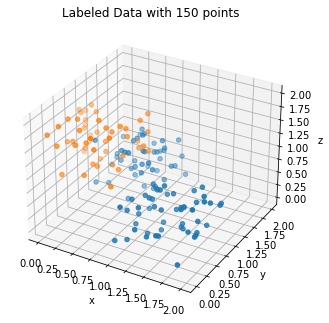

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_each = 50 # Number of points in each cluster
n_cluster = 3 # Number of clusters
N = N_each*n_cluster # Total number of points

xs = torch.rand(N)
ys = torch.rand(N)
zs = torch.rand(N)

# Cluster centers: (1,0,0) (0,1,0) (0,0,1)
xs[:N_each] += 1; ys[N_each:2*N_each] += 1; zs[2*N_each:3*N_each] += 1
Data = torch.stack((xs, ys, zs), 1)

# true labels
u_dagger = torch.cat((torch.ones(2*N_each), -1*torch.ones(N_each)))
Z_prime = [0,50,100] # Indices of labels
y = torch.sign(u_dagger) # One label is observed within each cluster

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs[:2*N_each], ys[:2*N_each], zs[:2*N_each], 'r')
ax.scatter(xs[2*N_each:3*N_each], ys[2*N_each:3*N_each], zs[2*N_each:3*N_each], 'b')
ax.set_title('Labeled Data with ' + str(N) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()


In [13]:
from time import perf_counter

if __name__ == "__main__":
# Initial Parameters
    eps = 0.15
    rval = 0.25 #threshold for kernel
    tau = 1
    alpha = 1
    g = 0.5 #Noise standard deviation
    n_eig = 20 #(62) truncation

    time_start = perf_counter()
    u_ast = u_ast_EL(Data, N, g, alpha, tau, eps, rval, y, Z_prime)
    print("Runtime for EL: " + str(perf_counter() - time_start))
    pred_error =  (sum(abs(torch.sign(u_ast) - torch.sign(u_dagger)))/(2*N)*100).item()
    print("Error for EL: " + str(pred_error))


    time_start = perf_counter()
    u_ast_2 = u_ast_NEWT(Data, N, g, alpha, tau, eps, rval, y, Z_prime)
    print("Runtime for Newton's: " + str(perf_counter() - time_start))
    pred_error =  (sum(abs(torch.sign(u_ast_2) - torch.sign(u_dagger)))/(2*N)*100).item()
    print("Error for Newton's: " + str(pred_error))
    
    time_start = perf_counter()
    u_ast_3 = u_ast_GRAD(Data, N, g, alpha, tau, eps, rval, y, Z_prime)
    print("Runtime for Newton's: " + str(perf_counter() - time_start))
    pred_error =  (sum(abs(torch.sign(u_ast_3) - torch.sign(u_dagger)))/(2*N)*100).item()
    print("Error for Newton's: " + str(pred_error))

Runtime for EL: 1.4319964660001006
Error for EL: 4.666666666666667
Runtime for Newton's: 1.5690125589999298
Error for Newton's: 0.6666666865348816
Runtime for Newton's: 1.7039024929999869
Error for Newton's: 4.0


## Using Kernel Flow method 

autograd do not support vectorization of the code, so can't compute and treat W as a matrix

In [14]:
import random

def select_Nf(N, Z_prime):
    '''
    N - (int) number of elements
    Z_prime - indices of labeled data
    '''
    N_f = int((N-len(Z_prime))/2) # Must be <= N
    half_Z = int(len(Z_prime)/2+1) # half of labels

    # Randomly selected indices N_f and N_c used for X,Y,Z
    # Always need to include Z' or else cant compute
    N_lst = range(N)
    N_f_i = random.sample(range(N), N_f)
    Z_half= random.sample(Z_prime, half_Z)
    for z in Z_half:
        if z not in N_f_i:
            N_f_i.append(z)

    return torch.tensor(N_f_i), Z_half

def optm_theta(X, N, Z_prime, y, theta_0, learning_rate, tol, maxiter):
    '''
    f - inputfunction
    theta_0 - initialization
    learning_rate - step size
    tol - tolerance for Gradient
    maxiter - maxmimum number of iterations
    '''
    g, alpha, tau, eps, rval = theta_0

    g = Variable(torch.tensor(g), requires_grad = True)
    alpha = Variable(torch.tensor(alpha), requires_grad = True)
    tau = Variable(torch.tensor(tau), requires_grad = True)
    eps = Variable(torch.tensor(eps), requires_grad = True)
    rval = Variable(torch.tensor(rval), requires_grad = True)
    
    for it in range(maxiter):
        # rho function given in [2]-(6)
        N_f_i, Z_half = select_Nf(N, Z_prime)
                
        uast = u_ast_GRAD(X, N, g, alpha, tau, eps, rval, y, Z_prime)
        uast_tild = u_ast_GRAD(X, N_f_i, g, alpha, tau, eps, rval, y, Z_half)

        # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
        # loop over each valid N_f_i
        num = 0.0
        denom = 0.0
        for u_i, nf_i in enumerate(N_f_i):
            num += (uast_tild[u_i] - uast[nf_i])**2
            denom += uast[nf_i]**2
        cost = num/denom
        
        print(str(it) + " | cost: " + str(cost.item()))
        
        cost.backward()
        with torch.no_grad():
            g -= learning_rate * g.grad
            alpha -= learning_rate * alpha.grad
            tau -= learning_rate * tau.grad
            eps -= learning_rate * eps.grad
            rval -= learning_rate * rval.grad

            g.grad = None
            alpha.grad = None
            tau.grad = None
            eps.grad = None
            rval.grad = None
            
        
        print(str(it) + " | theta: " + str(theta))
    return theta, it+1

In [15]:
g = 0.5; alpha = 1.; tau = 1.; eps = 0.15; rval = 0.25
learning_rate = 1e-7; tol=1e-08; maxiter=10

theta_0 = [g, alpha, tau, eps, rval]
theta, it = optm_theta(Data, N, Z_prime, y, theta_0, learning_rate, tol, maxiter)
print("Number of Iterations: " + str(it))
print("Theta: " + str(theta))


KeyboardInterrupt: 